In [1]:
library(fma)
library(forecast)
library(fpp)

Loading required package: tseries
Loading required package: forecast
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: expsmooth
Loading required package: lmtest


### 2a)
I don't know if this is in dollars or volume. I am going to assume dollars since there is a decimal value.

1990's Xmas peak was less than 89, but the rest increased YOY. The Xmas season is getting longer (starting earlier) since 1991. If this trend in seasonality increases (meaning if the xmas season keeps starting earlier and earlier each year), wouldn't be surprised if we see a straighter curve from Mar to Dec.

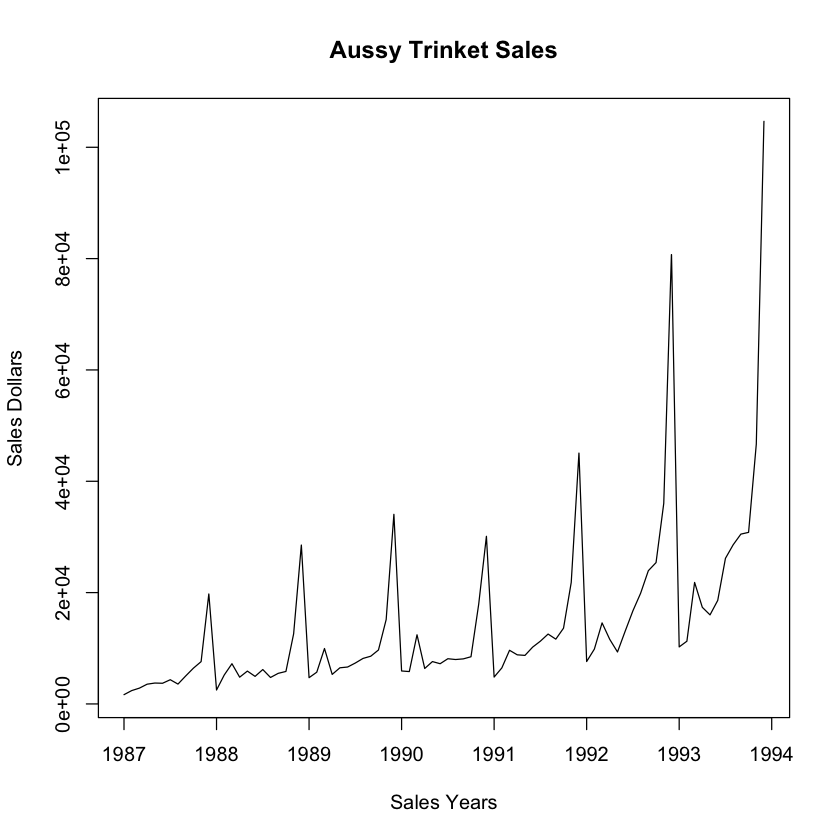

In [2]:
plot(fancy, main="Aussy Trinket Sales", ylab="Sales Dollars", xlab="Sales Years")

### 2b) Why Logs?

As the months progress in the year, the sales increase is more than just linear. So it seems good to try modeling with the log of sales as a first try.

In [3]:
# take the logarithm of sales dollars for each observation
fancy_log = log(fancy)

### 2c)

### Add Festival Dummy for each 3rd month of the year, except for the first year (since the festival didn't begin in our first year)

Found the following Cross-Validate q/a after I figured out how to do this. I like my way of doing it better, but at least this site gave me confidence that I was doing it right.

http://stats.stackexchange.com/questions/161614/time-series-regression-using-dummy-variables-and-fpp-package

In [4]:
# Create ts object that is mimic of fancy with 0s
dummy = replace(fancy, 1:length(fancy), 0)

# Update the proper Marchs, I am sure there is a mathematical way to do this, but I am not going to spend time on it
dummy = replace(dummy, c(15, 27, 39, 51, 63, 75), 1)

# Check on the dummy
dummy

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
1987   0   0   0   0   0   0   0   0   0   0   0   0
1988   0   0   1   0   0   0   0   0   0   0   0   0
1989   0   0   1   0   0   0   0   0   0   0   0   0
1990   0   0   1   0   0   0   0   0   0   0   0   0
1991   0   0   1   0   0   0   0   0   0   0   0   0
1992   0   0   1   0   0   0   0   0   0   0   0   0
1993   0   0   1   0   0   0   0   0   0   0   0   0

In [17]:
# Create the model
rm = tslm(fancy_log ~ trend + season + dummy)

### 2d) Residuals

It seems like the residuals revolve around 0. When plotted against time like this it seems like groups of times have meaning left over, so maybe we still have something left in the model to tweek out.

The histogram of the residuals is not really normally distributed either, almost though.

The residual Acf definitely doesn't look like white noise, meaning we still have something left in there to get out of our model.

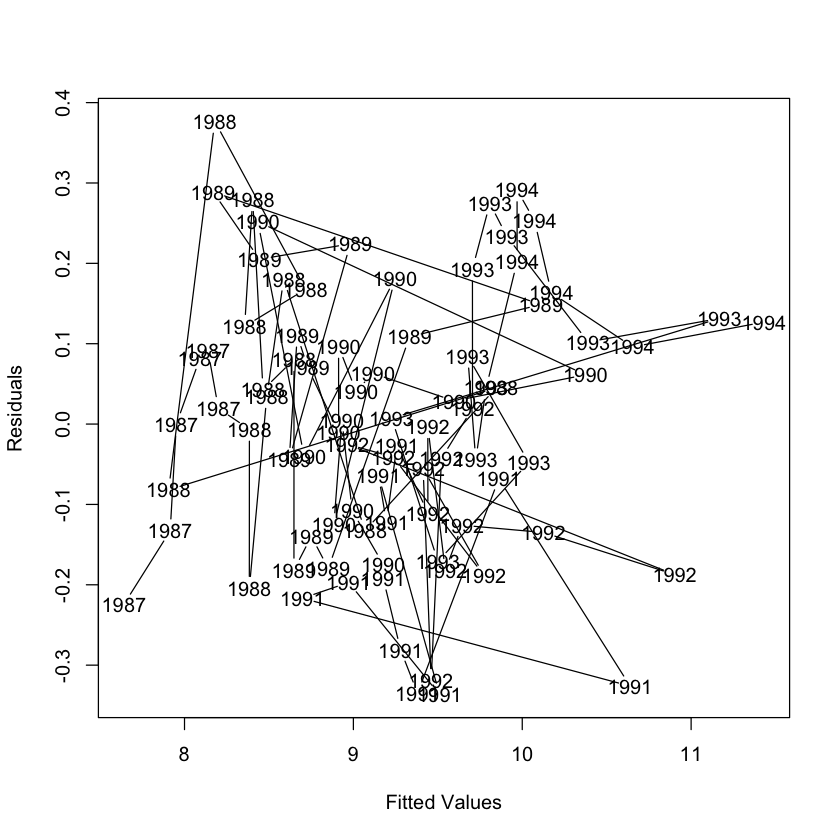

In [24]:
plot(fitted(rm), res, xlab="Fitted Values", ylab="Residuals")

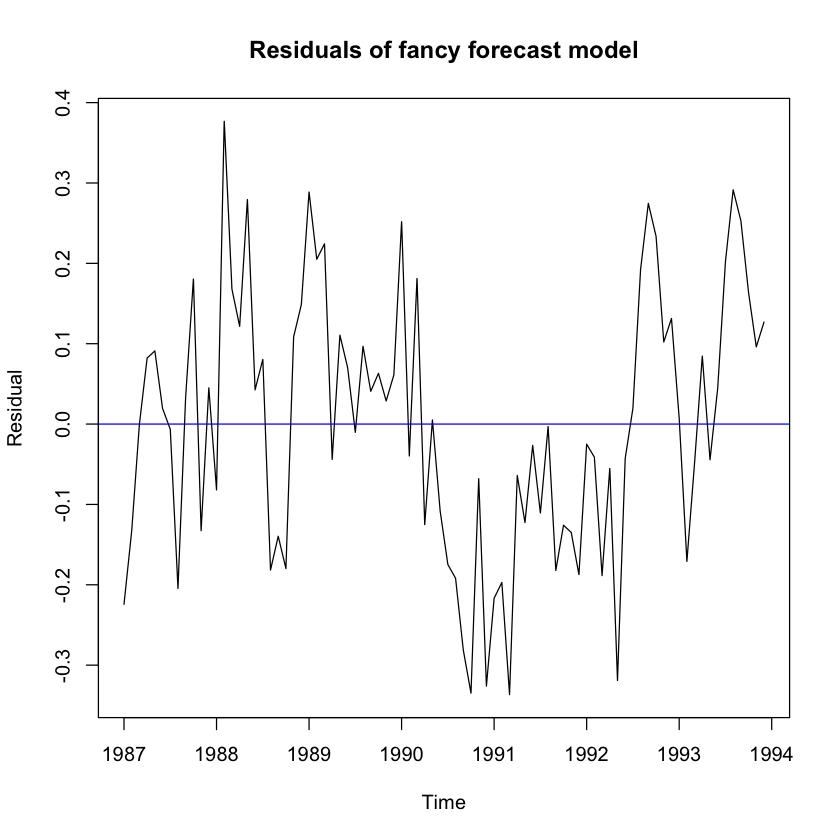

In [6]:
res = residuals(rm)

plot(res, main="Residuals of fancy forecast model", ylab="Residual")
abline(0, 0, col="blue")

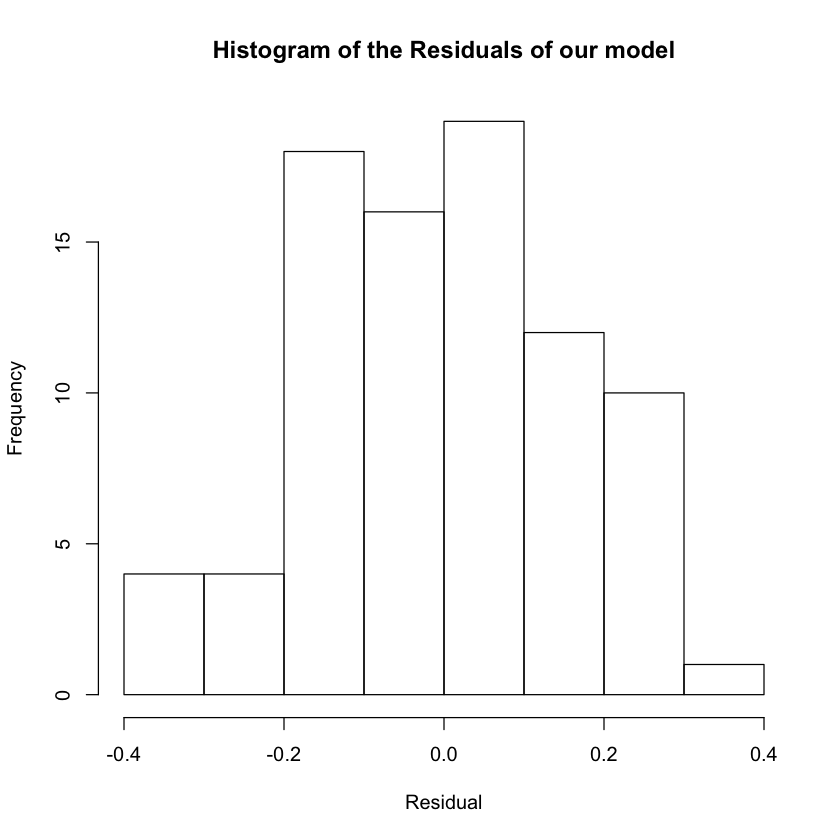

In [7]:
hist(res, main="Histogram of the Residuals of our model", xlab="Residual")

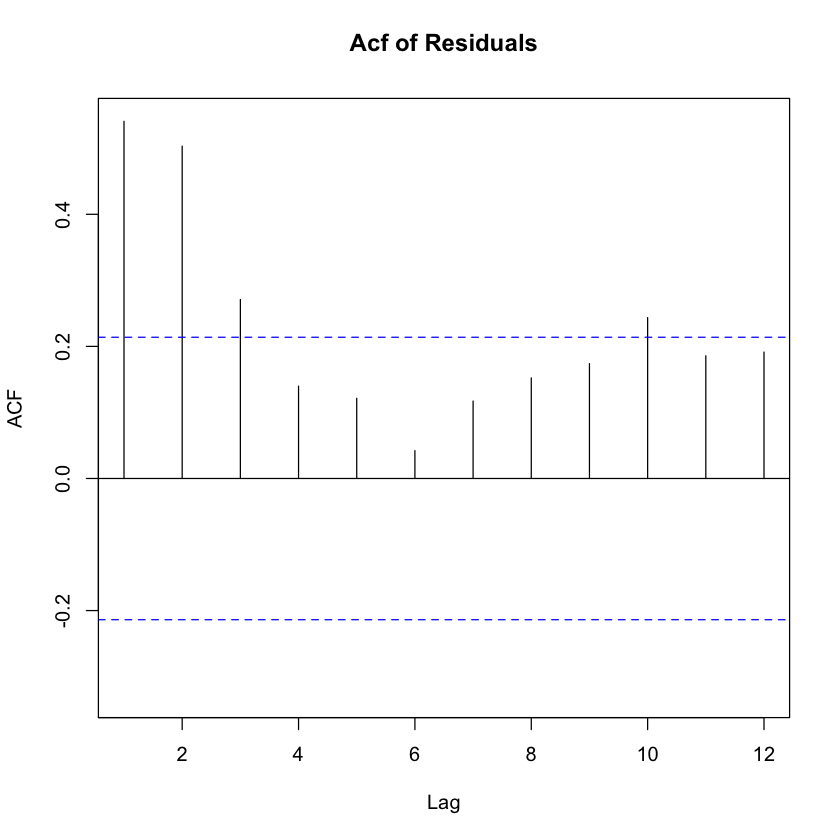

In [8]:
Acf(res, lag.max=12, main="Acf of Residuals")

### 2e) Boxplots

The means of each month are close to 0, but the later part of the year are all above 0. I think this means there is still some seasonality left in this.

Partly figured this out from here:

Boxploting:
http://www.togaware.com/datamining/survivor/Grouping_Time.html

Cycle function:
http://stats.stackexchange.com/questions/12980/subset-data-by-month-in-r

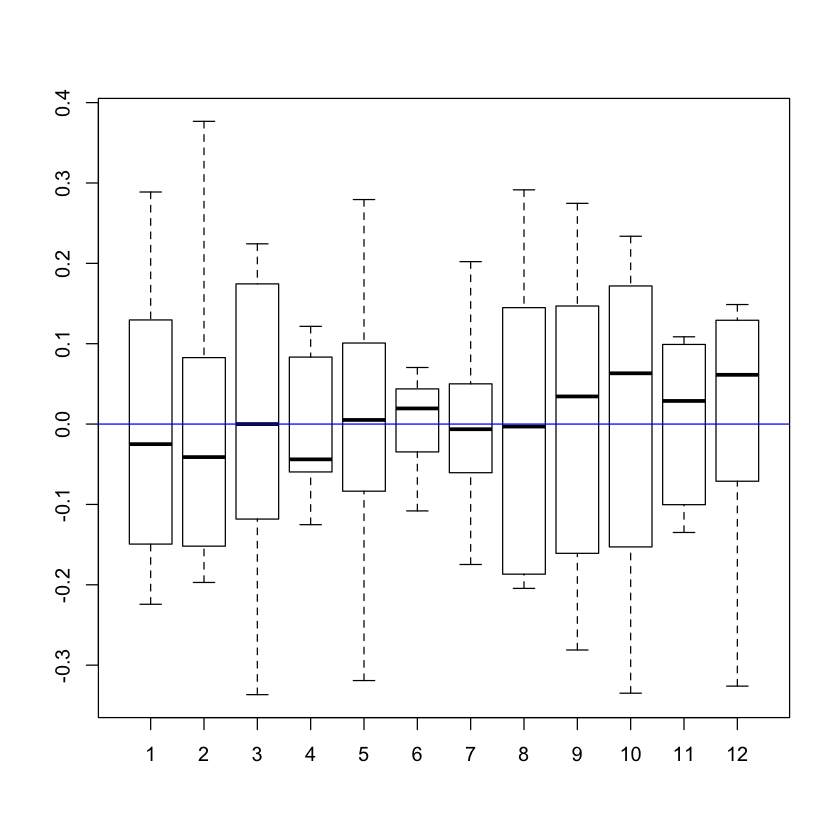

In [9]:
# Convert res into a data frame for easier manipulation
mydata = data.frame(res)

# Extract the Month part of the time series using the "cycle" function
mydata$month = cycle(res)

# Boxplot the residuals over the months
boxplot(mydata$res ~ mydata$month)
abline(0, 0, col="blue")

### 2f)
The model is reporting that most of the coefficients are statistically significant, except for season 3. Season 2 and our new dummy are not quite as significant as the rest.
The R-squared values are very high saying that this model does a really good job of explaining the dependent variable.

In [10]:
summary(rm)


Call:
tslm(formula = fancy_log ~ trend + season + dummy)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33673 -0.12757  0.00257  0.10911  0.37671 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.6196670  0.0742471 102.626  < 2e-16 ***
trend       0.0220198  0.0008268  26.634  < 2e-16 ***
season2     0.2514168  0.0956790   2.628 0.010555 *  
season3     0.2660828  0.1934044   1.376 0.173275    
season4     0.3840535  0.0957075   4.013 0.000148 ***
season5     0.4094870  0.0957325   4.277 5.88e-05 ***
season6     0.4488283  0.0957647   4.687 1.33e-05 ***
season7     0.6104545  0.0958039   6.372 1.71e-08 ***
season8     0.5879644  0.0958503   6.134 4.53e-08 ***
season9     0.6693299  0.0959037   6.979 1.36e-09 ***
season10    0.7473919  0.0959643   7.788 4.48e-11 ***
season11    1.2067479  0.0960319  12.566  < 2e-16 ***
season12    1.9622412  0.0961066  20.417  < 2e-16 ***
dummy       0.5015151  0.1964273   2.553 0.012856 *  
---
Signif. c

### 2g)

I believe we reject the null hypo that there is no autocorrelation here because D < 2. Wikipedia says that if 2 is less than 2 then there is evidence of positive serial correlation. This would go with all my other observations that there is something still to get out of our model.

In [11]:
dwtest(rm, alt="two.sided")


	Durbin-Watson test

data:  rm
DW = 0.88889, p-value = 1.956e-07
alternative hypothesis: true autocorrelation is not 0


### 2h)
Need to create the dataset that will be predicted, change March to True (assuming there will be future surfing festivals). I am pretty sure there is an easier way of doing this, but I cannot think of any.

In [12]:
# Create new data data set with a column named dummy that populates with 36 zeros
# rep(x, times) means replicate the values in x "times" number of times. In this case replicate the number 0 36 times.
future_dummy = data.frame(dummy = rep(0, 36))

# Change each March
future_dummy[3, 1] = 1
future_dummy[15, 1] = 1
future_dummy[27, 1] = 1

In [13]:
# Predict the Future
future = forecast(rm, newdata=future_dummy)
future

         Point Forecast     Lo 80     Hi 80     Lo 95    Hi 95
Jan 1994       9.491352  9.238522  9.744183  9.101594  9.88111
Feb 1994       9.764789  9.511959 10.017620  9.375031 10.15455
Mar 1994      10.302990 10.048860 10.557120  9.911228 10.69475
Apr 1994       9.941465  9.688635 10.194296  9.551707 10.33122
May 1994       9.988919  9.736088 10.241749  9.599161 10.37868
Jun 1994      10.050280  9.797449 10.303110  9.660522 10.44004
Jul 1994      10.233926  9.981095 10.486756  9.844168 10.62368
Aug 1994      10.233456  9.980625 10.486286  9.843698 10.62321
Sep 1994      10.336841 10.084010 10.589671  9.947083 10.72660
Oct 1994      10.436923 10.184092 10.689753 10.047165 10.82668
Nov 1994      10.918299 10.665468 11.171129 10.528541 11.30806
Dec 1994      11.695812 11.442981 11.948642 11.306054 12.08557
Jan 1995       9.755590  9.499844 10.011336  9.361338 10.14984
Feb 1995      10.029027  9.773281 10.284773  9.634775 10.42328
Mar 1995      10.567228 10.310518 10.823938 10.171489 1

### Forecast plot of LOG data

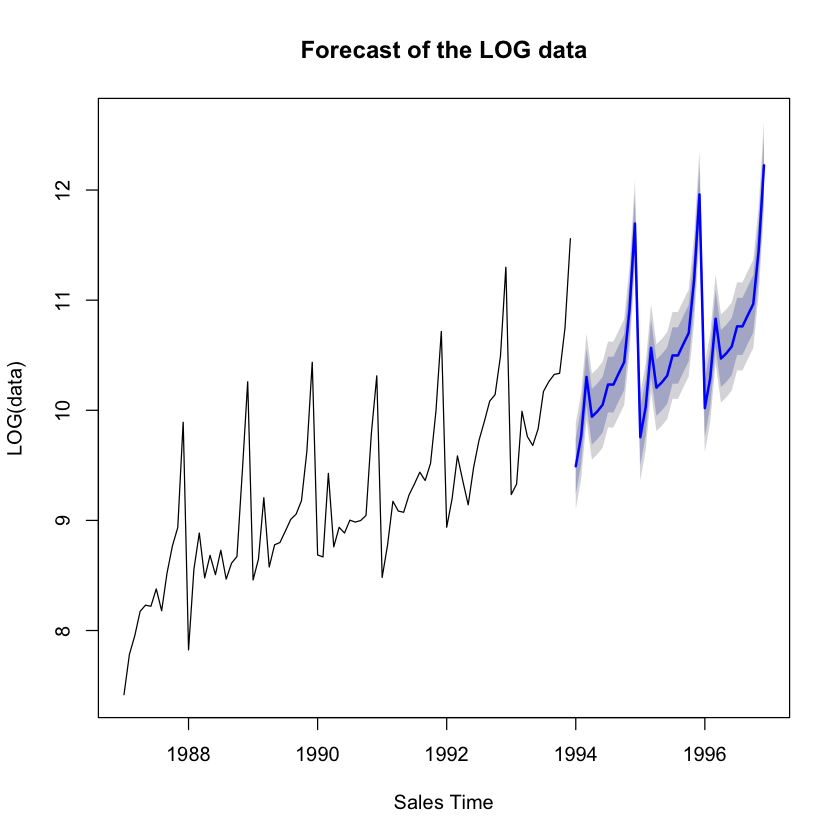

In [14]:
plot(future, main="Forecast of the LOG data", ylab="LOG(data)", xlab="Sales Time")

### 2i)
Convert back to regular numbers

Found this answer on good ole Stackoverflow

http://stackoverflow.com/questions/15673962/un-log-a-times-series-while-using-the-package-forecast

In [15]:
future_exp = future

# Convert Mean back
future_exp$mean = exp(future_exp$mean)
# Convert Upper back
future_exp$upper = exp(future_exp$upper)
# Convert Lower back
future_exp$lower = exp(future_exp$lower)
# Convert Original ts back
future_exp$x=exp(future_exp$x)

## THIS IS VERY COOL!

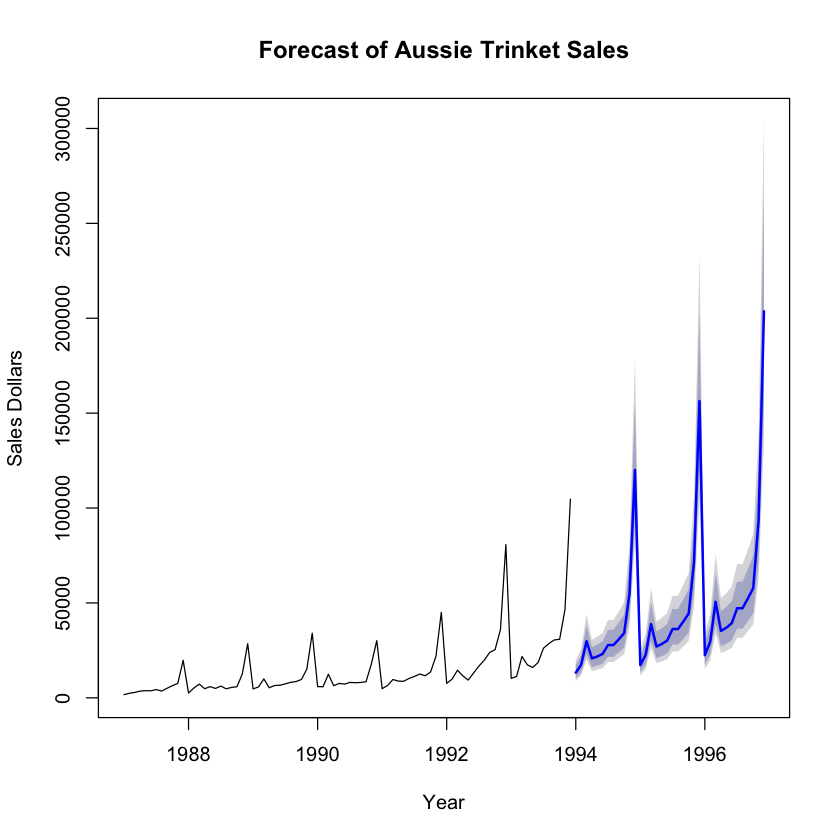

In [26]:
plot(future_exp, main="Forecast of Aussie Trinket Sales", xlab="Year", ylab="Sales Dollars")

### 2j)

First thing I would do is throw out the first year since it didn't have a festival. This way I can get rid of the dummy variable.

I want more data too. That way I can see how my predicted three years did.